In [2]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [3]:
logostxt=open(".\\carBrandLogos\\archive\\Car_Brand_Logos\\spisok.txt")
logos_list=logostxt.read().split("\n")
logos_list.sort()
CountOfClasses=len(logos_list)
print(CountOfClasses)
logos_list

8


['hyundai',
 'lexus',
 'mazda',
 'mercedes',
 'opel',
 'skoda',
 'toyota',
 'volkswagen']

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cuda


In [5]:
path = '.\\carBrandLogos\\archive\\Car_Brand_Logos\\Train'

In [6]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((160,160)),
    tv.transforms.ToTensor()
    
])

In [7]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [8]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=2,shuffle=True,)

(tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.7765, 0.7725, 0.7725],
         [0.7961, 0.7961, 0.7961,  ..., 0.7765, 0.7725, 0.7686],
         [0.7961, 0.7961, 0.7961,  ..., 0.7725, 0.7686, 0.7686],
         ...,
         [1.0000, 0.9961, 0.9804,  ..., 1.0000, 0.9882, 0.9922],
         [0.9922, 0.9961, 0.9765,  ..., 0.9922, 1.0000, 0.9922],
         [0.9961, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 0.9961]],

        [[0.8549, 0.8549, 0.8549,  ..., 0.8353, 0.8314, 0.8314],
         [0.8549, 0.8549, 0.8549,  ..., 0.8353, 0.8314, 0.8275],
         [0.8549, 0.8549, 0.8549,  ..., 0.8314, 0.8275, 0.8275],
         ...,
         [1.0000, 0.9961, 0.9804,  ..., 1.0000, 0.9882, 0.9922],
         [0.9843, 0.9882, 0.9686,  ..., 0.9922, 1.0000, 0.9922],
         [0.9922, 0.9961, 0.9922,  ..., 0.9961, 1.0000, 0.9961]],

        [[0.9451, 0.9451, 0.9451,  ..., 0.9255, 0.9216, 0.9216],
         [0.9451, 0.9451, 0.9451,  ..., 0.9255, 0.9216, 0.9176],
         [0.9451, 0.9451, 0.9451,  ..., 0.9216, 0.9176, 0

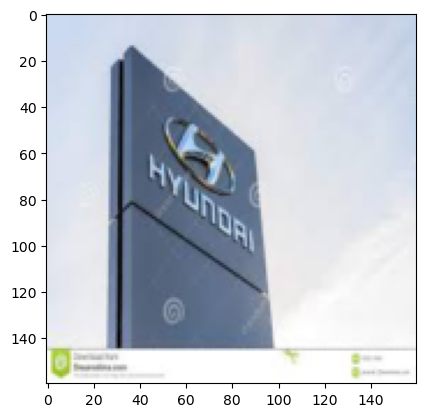

In [9]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [10]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [11]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=64):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,2*base_ch)

    cna3_1=CNA(2*base_ch,4*base_ch)
    cna3_2=CNA(4*base_ch,4*base_ch)
    
    cna4_1=CNA(4*base_ch,8*base_ch)
    cna4_2=CNA(8*base_ch,8*base_ch)
    #cna4_3=CNA(8*base_ch,8*base_ch)

    cna5_1=CNA(8*base_ch,8*base_ch)
    cna5_2=CNA(8*base_ch,8*base_ch)
    cna5_3=CNA(8*base_ch,8*base_ch)
    
    act=nn.ReLU()

    Linear_1=nn.Linear(8*base_ch,16*base_ch)
    Linear_2=nn.Linear(16*base_ch,4*base_ch)
    #Linear_3=nn.Linear(16*base_ch,8*base_ch)
    Linear_4=nn.Linear(4*base_ch,CountOfClasses)

    maxpool=nn.MaxPool2d((2,2),stride=2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,cna4_2,maxpool,
          #cna5_1,cna5_2,cna5_3,avgpool,
          cna5_1,cna5_2,avgpool,
          flatten,
          Linear_1,act,
          Linear_2,act,
          #Linear_3,act,
          Linear_4
          
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
# vggNet=tv.models.vgg.vgg19(weights=tv.models.VGG19_Weights)
# classifier=nn.Sequential(
#     nn.Linear(25088,600),
#     nn.ReLU(),
#     nn.Linear(600,600),
#     nn.ReLU(),
#     nn.Linear(600,CountOfClasses)
# )
# vggNet.classifier=classifier
# for param in vggNet.features.parameters():
#     param.requires_grad=False
# #net = SimpleConvNet()
# net=vggNet
# net = net.to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
#optimizer=torch.optim.Adam(net.classifier.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

10200648


In [13]:
def get_accuracy(pred, label):
    answer =(pred.argmax(1)==label.argmax(1)).type(torch.float).sum().item()

    #answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer

In [14]:
#net = torch.load('C:\\Users\\kryzh\\weightsOfLogoClassifierbatch1')

In [14]:
def realCheck():

    path=".\\carBrandLogos\\archive\\Car_Brand_Logos\\mytest\\2.jpg"
    img=Image.open(path)
    tensorImg=transforms(img)
    batchImg=torch.unsqueeze(tensorImg,0)
    batchImg=batchImg.to(device)
    out=net(batchImg)
    #print(out)
    test=out
    out=out.squeeze()
    out=out.tolist()
    #print(out)
    #print(max(out))
    #print(out.index(max(out)))
    print(logos_list[out.index(max(out))])
    #print(sum(out))
    y_pos = np.arange(len(logos_list))
    plt.bar(y_pos, out, align='center', alpha=0.5)
    plt.xticks(y_pos, logos_list)
    plt.ylabel('Value')
    plt.title('Bar title')

    plt.show()

In [16]:
net = torch.load('.\\weightsOfLogoClassifier')

In [16]:
epochs=50
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)
        
        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())
    

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)*2
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

epoch= 0 loss= 2.0809472251147056 accruracy= 0.1435958631662689
epoch= 1 loss= 2.0757031715760275 accruracy= 0.1467780429594272
epoch= 2 loss= 2.056942646429476 accruracy= 0.16785998408910102
epoch= 3 loss= 2.051904888786583 accruracy= 0.16945107398568018
epoch= 4 loss= 2.0330720015148747 accruracy= 0.1758154335719968
epoch= 5 loss= 2.0077026447039703 accruracy= 0.19291964996022276
epoch= 6 loss= 1.9711679238692672 accruracy= 0.21280827366746222
epoch= 7 loss= 1.942266626261299 accruracy= 0.2311058074781225
epoch= 8 loss= 1.897808304929316 accruracy= 0.24264120922832141
epoch= 9 loss= 1.84927969540313 accruracy= 0.26610978520286394
epoch= 10 loss= 1.7981573146491556 accruracy= 0.294351630867144
epoch= 11 loss= 1.7493318992184568 accruracy= 0.31941129673826574
epoch= 12 loss= 1.6856781852653127 accruracy= 0.3524264120922832
epoch= 13 loss= 1.6272121463489608 accruracy= 0.36953062848050916
epoch= 14 loss= 1.5594183331268026 accruracy= 0.4200477326968974
epoch= 15 loss= 1.4514063880760326

mercedes


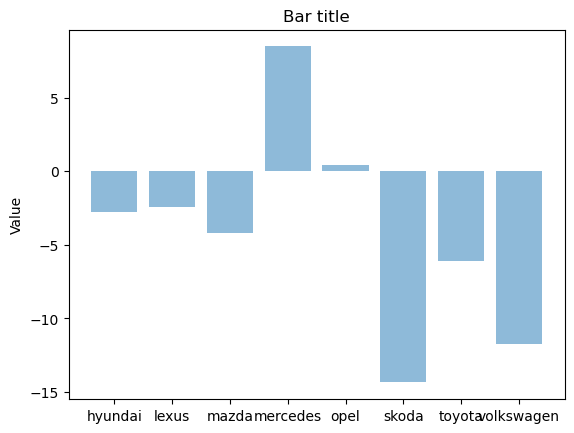

In [17]:

realCheck()

In [18]:
#torch.save(net, '.\\weightsOfLogoClassifier')

In [19]:
#net = MyConvModel()
#net = torch.load('.\\weightsOfLogoClassifier')
#net.eval()

In [18]:
a=np.zeros(CountOfClasses)
path = '.\\carBrandLogos\\archive\\Car_Brand_Logos\\Test'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)
    out=pred.squeeze()
    out=out.tolist()
    a[out.index(max(out))]+=1
    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    
loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)
print(a)
print(sum(a))

loss= 1.4632306166973195 accruracy= 0.7375
[38. 52. 68. 52. 62. 38. 47. 43.]
400.0


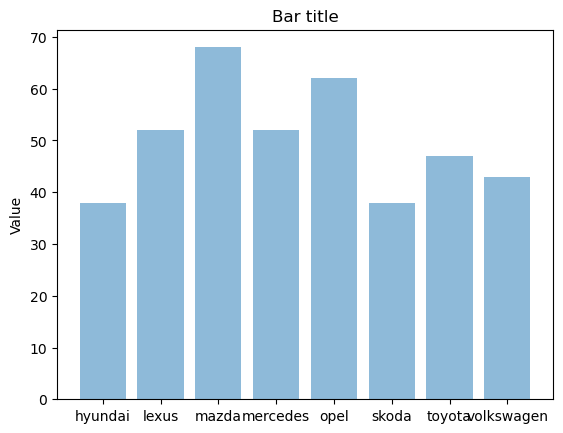

In [19]:
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()